# Imports

In [1]:
import pandas as pd
import os

from dotenv import load_dotenv

# pandasai imports
from pandasai.llm.openai import OpenAI
from pandasai import SmartDataframe
from pandasai import clear_cache
from pandasai import Agent

# Initialization

In [2]:
READ_FROM_PICKLE = True

In [3]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

In [4]:
if READ_FROM_PICKLE:
    malicious_df = pd.read_pickle("data/malicious_features.pkl")
    benign_df = pd.read_pickle("data/benign_features.pkl")

In [5]:
# Instantiate a LLM
llm = OpenAI(api_token=openai_api_key)

In [6]:
malicious_smart = SmartDataframe(
    df=pd.DataFrame(malicious_df),
    config={"llm": llm, "verbose": True},
    name="Mirai botnet network packet capture.",
    description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.",
)

In [7]:
benign_smart = SmartDataframe(
    df=pd.DataFrame(benign_df),
    config={"llm": llm, "verbose": True},
    name="Packet capture of normal operation network travvid.",
    description="A dataframe that is derived from a packet capture of the regular operation of a network.",
)

In [8]:
malicious_smart.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Payload',
       'Packet Length', 'Protocol', 'src_ip_total_bytes', 'dst_ip_total_bytes',
       'Numeric Source IP', 'Numeric Destination IP', 'dst_port_freq_encoded',
       'Interarrival', 'ICMP', 'TCP', 'UDP', 'Telnet', 'IPv6_encapsulation',
       'GRE', 'ESP', 'AH', 'DNS', 'ICMPv6', 'OSPF', 'SCTP', 'UDPLite',
       'NETBIOS-NS', 'NETBIOS-DGM', 'NETBIOS-SSN', 'IMAP', 'SNMP', 'SNMP_trap',
       'HTTPS', 'Syslog', 'LDAPS', 'FTPS', 'IMAPS', 'POP3S', 'SOCKS_proxy'],
      dtype='object')

# EDA

## Statistical

### Exploration via prompting

In [9]:
top_5_source_IPs = malicious_smart.chat("Which are the 5 most popular source IP addresses?")

top_5_source_IPs

2024-05-03 10:46:31 [INFO] Question: Which are the 5 most popular source IP addresses?
2024-05-03 10:46:31 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:46:31 [INFO] Prompt ID: 1d33eb17-13f4-4807-9023-8874413c8bdf
2024-05-03 10:46:31 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:46:31 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:46:32 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26,6205924968,874070778,0.04079

,Numeric Source IP,Count
0,3232236140,51747
1,3232236145,34415
2,3232236142,16520
3,3232236147,13486
4,3232236144,9158


In [10]:
print(malicious_smart.last_code_generated)

source_ip_counts = dfs[0]['Numeric Source IP'].value_counts().head(5).reset_index()
source_ip_counts.columns = ['Numeric Source IP', 'Count']
result = {'type': 'dataframe', 'value': source_ip_counts}


In [11]:
top_5_dst_ports = malicious_smart.chat("Find the most used destination ports.")
top_5_dst_ports

2024-05-03 10:46:36 [INFO] Question: Find the most used destination ports.
2024-05-03 10:46:36 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:46:36 [INFO] Prompt ID: 50d2e965-720e-4790-8bc0-fc2474dce886
2024-05-03 10:46:36 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:46:37 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:46:37 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26,6205924968,874070778,0.04079434096956324

,Destination Port,Count
0,10240.0,62584
1,53.0,33348
2,80.0,17644
3,23.0,9466
4,21897.0,7158


In [12]:
print(malicious_smart.last_code_generated)

destination_ports = dfs[0]['Destination Port'].value_counts().head().reset_index()
destination_ports.columns = ['Destination Port', 'Count']
result = {'type': 'dataframe', 'value': destination_ports}


### Prompt engineering

In [13]:
rare_ports = malicious_smart.chat(
    "Which are the most rarely used destination ports within the range of 0-1024?"
)
rare_ports

2024-05-03 10:46:43 [INFO] Question: Which are the most rarely used destination ports within the range of 0-1024?
2024-05-03 10:46:43 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:46:43 [INFO] Prompt ID: f6694ce4-6a68-4390-8653-ed25feb82bd1
2024-05-03 10:46:43 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:46:43 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:46:43 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26,6

'The most rarely used destination ports within the range of 0-1024 are: 51139.0, 1442.0, 1443.0, 1410.0, 1475.0, 1413.0, 1415.0, 1469.0, 1414.0, 1709.0, 1417.0, 1468.0, 1472.0, 1474.0, 1438.0, 1440.0, 1439.0, 1416.0, 1409.0, 1470.0, 1473.0, 1453.0, 1654.0, 1455.0, 1434.0, 1425.0, 1426.0, 1427.0, 1456.0, 1428.0, 1454.0, 1710.0, 1430.0, 34285.0, 1651.0, 1431.0, 1432.0, 1433.0, 1435.0, 1713.0, 1458.0, 1450.0, 1449.0, 1460.0, 1421.0, 1448.0, 1419.0, 59903.0, 1461.0, 1418.0, 55998.0, 1447.0, 1464.0, 1444.0, 1649.0, 1653.0, 1373.0, 1408.0, 1716.0, 1349.0, 1350.0, 1351.0, 54709.0, 1352.0, 1353.0, 1354.0, 1355.0, 1356.0, 1357.0, 1658.0, 1358.0, 1359.0, 1360.0, 1361.0, 1362.0, 1717.0, 1348.0, 1347.0, 1346.0, 56533.0, 1329.0, 1330.0, 1331.0, 1332.0, 1333.0, 1334.0, 1335.0, 1336.0, 1345.0, 1337.0, 1338.0, 1339.0, 1340.0, 1341.0, 1342.0, 1344.0, 1363.0, 1364.0, 1407.0, 1365.0, 1659.0, 1387.0, 1389.0, 1390.0, 1391.0, 1392.0, 1393.0, 1395.0, 1396.0, 1397.0, 1398.0, 1399.0, 1400.0, 1403.0, 1404.0, 14

In [14]:
rare_ports = malicious_smart.chat(
    "Which are the most rarely used destination ports less than or equal to 1024?"
)
rare_ports

2024-05-03 10:46:46 [INFO] Question: Which are the most rarely used destination ports less than or equal to 1024?
2024-05-03 10:46:46 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:46:46 [INFO] Prompt ID: 4a99158c-6bbb-448e-ac41-6583c0dce3e8
2024-05-03 10:46:46 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:46:46 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:46:46 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26,6

,Destination Port,Count
0,123.0,190
1,68.0,136
2,67.0,27
3,138.0,18
4,137.0,15


### Correlation

In [15]:
correlation = malicious_smart.chat(
    """1. Calculate the correlation between the source port and the length of a packet.
       2. Explain if the correlation that you calculated is significant and why.
    """
)
correlation

2024-05-03 10:46:51 [INFO] Question: 1. Calculate the correlation between the source port and the length of a packet.
       2. Explain if the correlation that you calculated is significant and why.
    
2024-05-03 10:46:51 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:46:51 [INFO] Prompt ID: 2f9a4f9b-07f0-4f6b-8c45-0cf91dfbc0d7
2024-05-03 10:46:51 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:46:51 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:46:51 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,

-0.16566431740345833

In [16]:
hypothesis = malicious_smart.chat(
    "Is the difference between dst_ip_total_bytes and Packet Length statistically significant?"
)
hypothesis

2024-05-03 10:46:56 [INFO] Question: Is the difference between dst_ip_total_bytes and Packet Length statistically significant?
2024-05-03 10:46:56 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:46:56 [INFO] Prompt ID: 617e6568-ce9a-44ee-b717-08bfa96dbce0
2024-05-03 10:46:56 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:46:56 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:46:56 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,2

'The difference between dst_ip_total_bytes and Packet Length is statistically significant.'

In [17]:
outliers = malicious_smart.chat(
    "Find the z score of the Packet Length and then calculate the top ten outliers."
)
outliers

2024-05-03 10:47:02 [INFO] Question: Find the z score of the Packet Length and then calculate the top ten outliers.
2024-05-03 10:47:02 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:02 [INFO] Prompt ID: dcdece2c-788d-4a47-90d1-b1104e476625
2024-05-03 10:47:02 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:02 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:03 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,...,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy,Packet Length Z Score
581,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2000,311,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
582,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2166,477,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
583,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2332,643,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
1012,1.540446e+09,67.0,68.0,BOOTP,166,17.0,1791,166,3232236033,4294967295,...,0,0,0,0,0,0,0,0,0,6.874108
1351,1.540446e+09,1215.0,1900.0,Raw,166,17.0,5709,809,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
1352,1.540446e+09,1215.0,1900.0,Raw,166,17.0,5875,975,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
1353,1.540446e+09,1215.0,1900.0,Raw,166,17.0,6041,1141,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
2257,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9468,1597,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
2258,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9634,1763,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108
2259,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9800,1929,3232236147,4026531834,...,0,0,0,0,0,0,0,0,0,6.874108


## Visual

2024-05-03 10:47:06 [INFO] Question: Plot the histogram of src_ip_total_bytes with purple color.
2024-05-03 10:47:06 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:06 [INFO] Prompt ID: fc9d2d14-fa02-4d69-9103-ae59b89483d4
2024-05-03 10:47:06 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:06 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:07 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26,6205924968,8740707

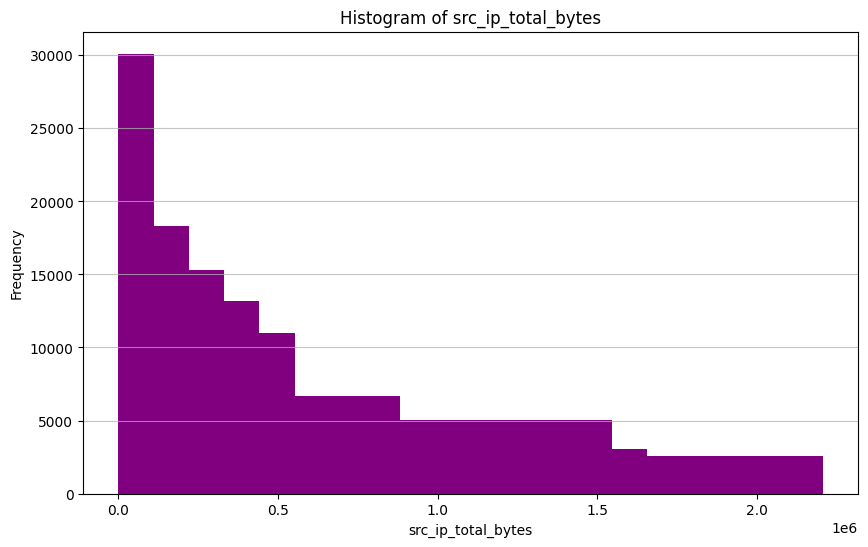

2024-05-03 10:47:11 [WARNING] Failed to execute code with a correction framework [retry number: 1]
2024-05-03 10:47:11 [ERROR] Failed with error: Traceback (most recent call last):
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/pipelines/smart_datalake_chat/code_execution.py", line 46, in execute
    result = pipeline_context.query_exec_tracker.execute_func(
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 134, in execute_func
    step_data = self._generate_exec_step(tag, result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 183, in _generate_exec_step
    self._response = self._format_response(result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 205, in _format_response
    with open(result["value"], "rb") as image_file:
File

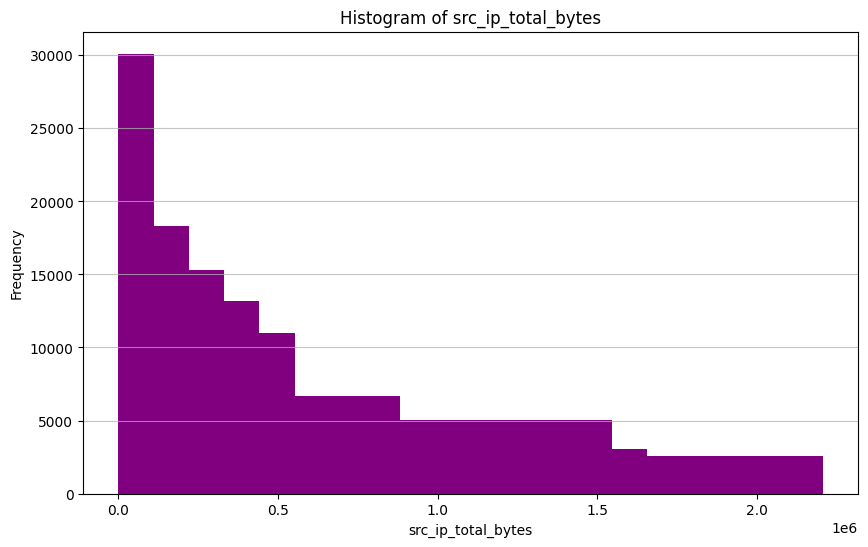

2024-05-03 10:47:15 [WARNING] Failed to execute code with a correction framework [retry number: 2]
2024-05-03 10:47:15 [ERROR] Failed with error: Traceback (most recent call last):
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/pipelines/smart_datalake_chat/code_execution.py", line 46, in execute
    result = pipeline_context.query_exec_tracker.execute_func(
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 134, in execute_func
    step_data = self._generate_exec_step(tag, result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 183, in _generate_exec_step
    self._response = self._format_response(result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 205, in _format_response
    with open(result["value"], "rb") as image_file:
Type

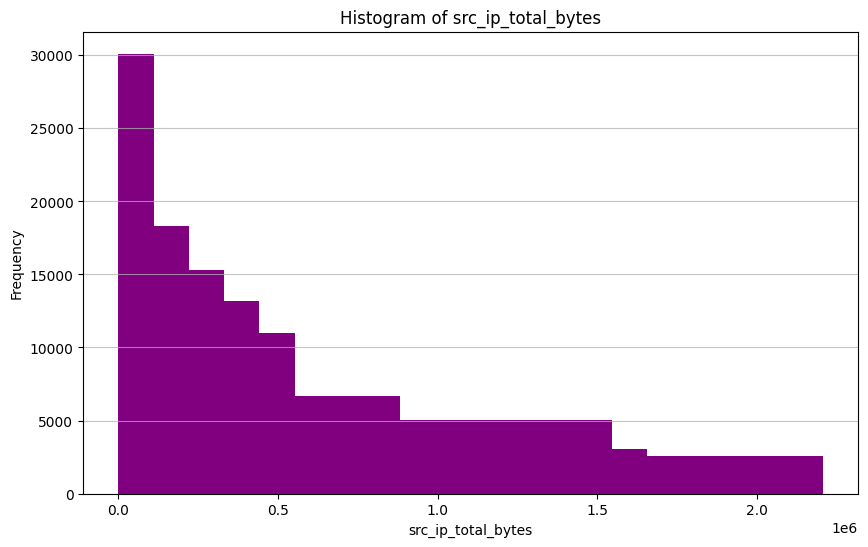

2024-05-03 10:47:18 [ERROR] Pipeline failed on step 4: expected str, bytes or os.PathLike object, not module


'Unfortunately, I was not able to answer your question, because of the following error:\n\nexpected str, bytes or os.PathLike object, not module\n'

In [18]:
malicious_smart.chat(
    "Plot the histogram of src_ip_total_bytes with purple color."
)

In [19]:
print(malicious_smart.last_code_executed)

plt.figure(figsize=(10, 6))
plt.hist(dfs[0]['src_ip_total_bytes'], color='purple', bins=20)
plt.title('Histogram of src_ip_total_bytes')
plt.xlabel('src_ip_total_bytes')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
result = {'type': 'plot', 'value': plt}


2024-05-03 10:47:18 [INFO] Question: Plot the histogram dst_port_freq_encoded.
2024-05-03 10:47:18 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:18 [INFO] Prompt ID: 50289d84-5408-4460-bc6d-ed46775ca031
2024-05-03 10:47:18 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:18 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:18 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,UDPLite,NETBIOS-NS,NETBIOS-DGM,NETBIOS-SSN,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
3402941676,20532.0,8280.0,Padding,26,6.0,52,26,6205924968,874070778,0.0407943409695

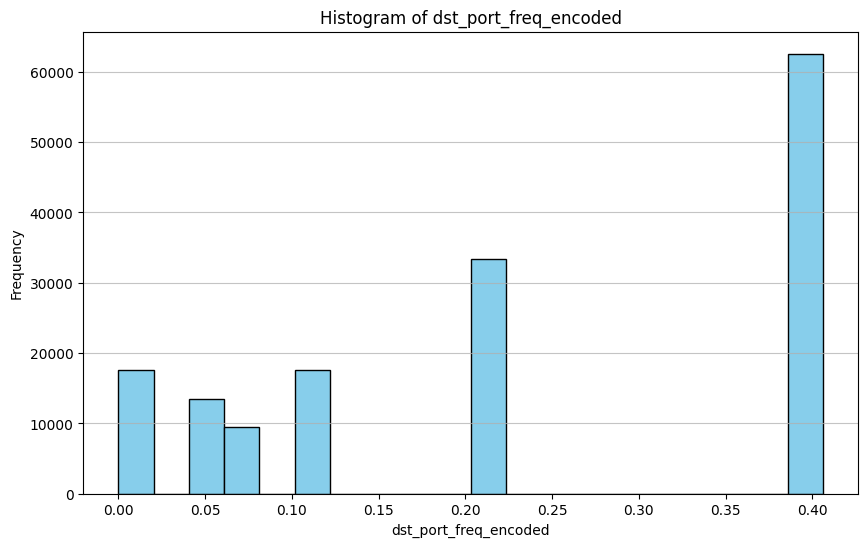

2024-05-03 10:47:22 [WARNING] Failed to execute code with a correction framework [retry number: 1]
2024-05-03 10:47:22 [ERROR] Failed with error: Traceback (most recent call last):
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/pipelines/smart_datalake_chat/code_execution.py", line 46, in execute
    result = pipeline_context.query_exec_tracker.execute_func(
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 134, in execute_func
    step_data = self._generate_exec_step(tag, result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 183, in _generate_exec_step
    self._response = self._format_response(result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 205, in _format_response
    with open(result["value"], "rb") as image_file:
Type

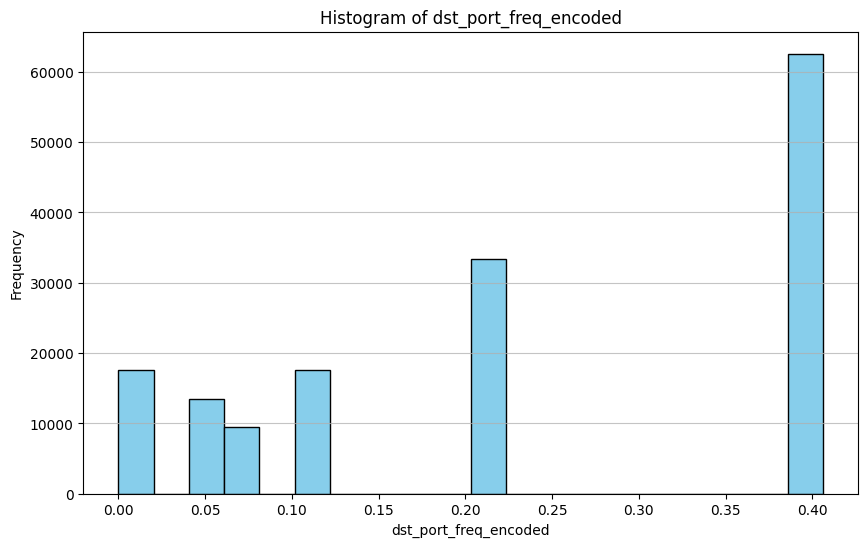

2024-05-03 10:47:26 [WARNING] Failed to execute code with a correction framework [retry number: 2]
2024-05-03 10:47:26 [ERROR] Failed with error: Traceback (most recent call last):
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/pipelines/smart_datalake_chat/code_execution.py", line 46, in execute
    result = pipeline_context.query_exec_tracker.execute_func(
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 134, in execute_func
    step_data = self._generate_exec_step(tag, result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 183, in _generate_exec_step
    self._response = self._format_response(result)
  File "/home/drx/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 205, in _format_response
    with open(result["value"], "rb") as image_file:
Type

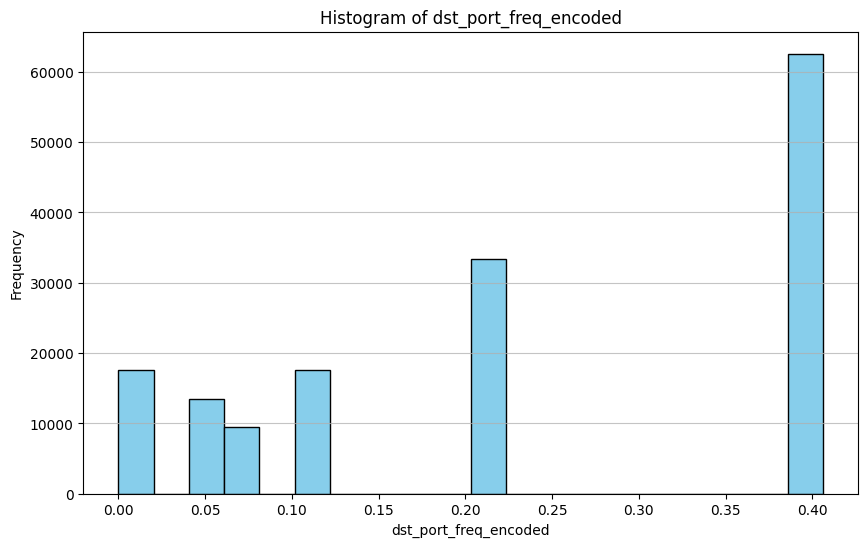

2024-05-03 10:47:30 [ERROR] Pipeline failed on step 4: expected str, bytes or os.PathLike object, not module


'Unfortunately, I was not able to answer your question, because of the following error:\n\nexpected str, bytes or os.PathLike object, not module\n'

In [20]:
malicious_smart.chat("Plot the histogram dst_port_freq_encoded.")

In [21]:
print(malicious_smart.last_code_executed)

plt.figure(figsize=(10, 6))
plt.hist(dfs[0]['dst_port_freq_encoded'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of dst_port_freq_encoded')
plt.xlabel('dst_port_freq_encoded')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()
result = {'type': 'plot', 'value': plt}


# Agents

In [22]:
from pandasai import Agent

In [23]:
agent = Agent(malicious_smart, config={"llm": llm},memory_size=1000)

In [ ]:
agent.chat('Is this dataframe indicating malicious or benign network behavior?')

2024-05-03 10:47:33 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-03 10:47:33 [INFO] Check if the new message is related to the conversation: True
2024-05-03 10:47:33 [INFO] Question: Is this dataframe indicating malicious or benign network behavior?
2024-05-03 10:47:33 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:33 [INFO] Prompt ID: 710244b7-37e1-4764-be7a-3008ee1cb816
2024-05-03 10:47:33 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:33 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:34 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,E

'The dataframe indicates malicious network behavior.'

In [24]:
agent.chat('The dataframe that you have been given is a packet capture of computer network traffic. It has numerical features that characterize the packets that have been observed in this network. A packet capture is malicious if it has too many requests to ports that are unusual. Usual ports are 443 for HTTPS and 22 for SSH. Is this packet capture malicious or benign?')

2024-05-03 10:47:30 [INFO] Question: The dataframe that you have been given is a packet capture of computer network traffic. It has numerical features that characterize the packets that have been observed in this network. A packet capture is malicious if it has too many requests to ports that are unusual. Usual ports are 443 for HTTPS and 22 for SSH. Is this packet capture malicious or benign?
2024-05-03 10:47:30 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:30 [INFO] Prompt ID: 10d01b59-b528-429c-9df9-626c737c482c
2024-05-03 10:47:30 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:31 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:31 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numer

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,...,IMAP,SNMP,SNMP_trap,HTTPS,Syslog,LDAPS,FTPS,IMAPS,POP3S,SOCKS_proxy
0,1.540446e+09,21074.0,80.0,Padding,26,6.0,26,26,3232236140,873999171,...,0,0,0,0,0,0,0,0,0,0
1,1.540446e+09,20532.0,8280.0,Padding,26,6.0,52,26,3232236140,874070778,...,0,0,0,0,0,0,0,0,0,0
7,1.540446e+09,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,83,83,3232236147,3232236033,...,0,0,0,0,0,0,0,0,0,0
8,1.540446e+09,53.0,2440.0,DNS Ans,83,17.0,83,83,3232236033,3232236147,...,0,0,0,0,0,0,0,0,0,0
9,1.540446e+09,21074.0,80.0,Padding,26,6.0,78,52,3232236140,873999171,...,0,0,0,0,0,0,0,0,0,0


In [26]:
agent.explain()

2024-05-03 10:47:38 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-03 10:47:38 [INFO] Explanation:  I looked at the data provided and extracted the first few rows to show what it looks like. Then, I wrote a statement saying that the data indicates malicious network behavior.
                


'I looked at the data provided and extracted the first few rows to show what it looks like. Then, I wrote a statement saying that the data indicates malicious network behavior.'

In [27]:
agent.chat('Which features of the packet capture did you review to identify it as malicious?')

2024-05-03 10:47:38 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-03 10:47:38 [INFO] Check if the new message is related to the conversation: True
2024-05-03 10:47:39 [INFO] Question: Which features of the packet capture did you review to identify it as malicious?
2024-05-03 10:47:39 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:39 [INFO] Prompt ID: 33aaab01-1db2-4311-a7ba-54da5d6dc478
2024-05-03 10:47:39 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:39 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:39 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encap

'The dataframe indicates malicious network behavior.'

In [28]:
agent.chat("Why do you think it is not malicious?")

2024-05-03 10:47:43 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-03 10:47:43 [INFO] Check if the new message is related to the conversation: False
2024-05-03 10:47:43 [INFO] Question: Why do you think it is not malicious?
2024-05-03 10:47:43 [INFO] Running PandasAI with openai LLM...
2024-05-03 10:47:43 [INFO] Prompt ID: e36d6513-d6b7-4627-b0cd-5a8a9c7be699
2024-05-03 10:47:43 [INFO] Executing Step 0: CacheLookup
2024-05-03 10:47:43 [INFO] Executing Step 1: PromptGeneration
2024-05-03 10:47:43 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x38
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,ICMP,TCP,UDP,Telnet,IPv6_encapsulation,GRE,ESP,AH,DNS,ICMPv6,OSPF,SCTP,U

'The network traffic is not malicious: False'

# Clear cache

In [29]:
clear_cache()